### Hausdorff SE match plots L = 2, unif prior

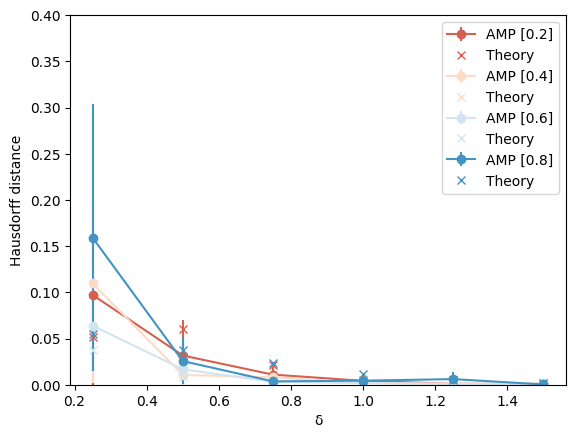

In [1]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import jax
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 1000
σ = 0.1 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
# δ_list = [0.25, 0.5]

# --- Preliminaries ---
# Changepoint locations
Δ = lambda n: int(n/10)
Lmin = 2
Lmax = 2 # TODO: ground truth is L=4 cell stages (3 chgpts).

num_outer_samples = 10

seed = 29
nprandom.seed(2*seed)

### Open the save and plot
out = np.load("coverage_data_v2.npz")
empirical_hausdorff = out["empirical_hausdorff"]
empirical_hausdorff_std = out["empirical_hausdorff_std"]
theory_hausdorff = out["theory_hausdorff"]
theory_hausdorff_std = out["theory_hausdorff_std"]
chgpt_location_idx = out["chgpt_location_idx"]
δ_list = out["δ_list"]


### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
fig = plt.figure()
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0.2, 0.8, (len(chgpt_location_idx)))]
for i in range(0, len(chgpt_location_idx), 2):
    plt.errorbar(δ_list, empirical_hausdorff[i], yerr = empirical_hausdorff_std[i], label="AMP " + str([chgpt_location_idx[i]]) , marker="o", ls="-", c=colors[i], alpha = 1)
    plt.errorbar(δ_list, theory_hausdorff[i], label="Theory", marker="x", ls="", c=colors[i], alpha = 1)
# plt.plot(np.array(δ_list), empirical_hausdorff.T, label="Empirical", marker="o", ls="--", alpha = 1)
# plt.plot(np.array(δ_list), theory_hausdorff.T, label="Theory", marker="x", ls="", alpha = 1)
# plt.bar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.04, color='orange', label='Empirical', alpha = 0.5)
# plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', alpha = 0.5)
plt.xlabel("δ")
plt.ylabel("Hausdorff distance")
# plt.title(str("p = ", str(p), " σ = ", str(σ), " num_outer_samples = ", str(num_outer_samples), "δ = ", str(δ), "\Delta = ", str(Δ(n)/n)))
plt.legend()
plt.ylim((0, 0.4))
plt.savefig("hausdorff_1_chgpt_v2.pdf")

### Hausdorff SE match L = 3

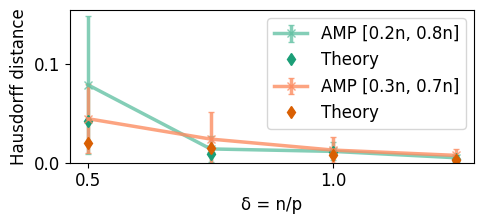

In [93]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import jax
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 1000
σ = 0.1 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
# δ_list = [0.25, 0.5]
possible_chgpt_configurations = [[0.2, 0.8], [0.3, 0.7], [0.4, 0.6]]

# --- Preliminaries ---
# Changepoint locations
Δ = lambda n: int(n/10)
Lmin = 2
Lmax = 2 # TODO: ground truth is L=4 cell stages (3 chgpts).

num_outer_samples = 10

seed = 29
nprandom.seed(2*seed)

### Open the save and plot
out = np.load("coverage_data_2chgpt_v2.npz")
empirical_hausdorff = out["empirical_hausdorff"]
empirical_hausdorff_std = out["empirical_hausdorff_std"]
theory_hausdorff = out["theory_hausdorff"]
theory_hausdorff_std = out["theory_hausdorff_std"]
chgpt_location_idx = out["chgpt_location_idx"]
δ_list = out["δ_list"]

### Plot the mean estimated coverage over chgpt_location_idx, theoretical versus empirical, as barplots
fig = plt.figure(figsize = (5, 2.4))
cmap = plt.get_cmap('RdBu')
plt.rcParams.update({'font.size': 12})
# colors = [cmap(i) for i in np.linspace(0.2, 0.8, (len(possible_chgpt_configurations)))]
# colors = ['C0', 'C1', 'C2']
# poss_sign_config_n = [str(possible_chgpt_configurations[i]) + 'n' for i in range(len(possible_chgpt_configurations))]
poss_sig_config_n = []
for i in range(len(possible_chgpt_configurations)):
    poss_sig_config_n.append([str(possible_chgpt_configurations[i][j]) + str("n") for j in range(len(possible_chgpt_configurations[i]))])

poss_sig_config_n_2 = ['[0.2n, 0.8n]', '[0.3n, 0.7n]', '[0.4n, 0.6n]']

colors_dark = ['#1b9e77','#d95f02','#7570b3'] # darker
colors_light = ['#66c2a5','#fc8d62','#8da0cb'] # lighter
for i in range(0, len(possible_chgpt_configurations)-1):
    plt.errorbar(δ_list, empirical_hausdorff[i], yerr = empirical_hausdorff_std[i], label="AMP " + str(poss_sig_config_n_2[i]), marker="x", ls="-", c=colors_light[i], alpha = 0.8, capsize=2, linewidth=2.5)
    plt.errorbar(δ_list, theory_hausdorff[i], label="Theory", marker="d", ls="", c=colors_dark[i], alpha = 1.0)
# plt.plot(np.array(δ_list), empirical_hausdorff.T, label="Empirical", marker="o", ls="--", alpha = 1)
# plt.plot(np.array(δ_list), theory_hausdorff.T, label="Theory", marker="x", ls="", alpha = 1)
# plt.bar(chgpt_location_idx, np.mean(coverage_list, axis=1), yerr= np.std(coverage_list, axis=1), width = 0.04, color='orange', label='Empirical', alpha = 0.5)
# plt.errorbar(chgpt_location_idx, np.mean(theoretical_coverage_list, axis=1), yerr = np.std(theoretical_coverage_list, axis=1), color='purple', label='Theoretical', marker='x', alpha = 0.5)
plt.xlabel("δ = n/p")
plt.ylabel("Hausdorff distance")
# plt.title(str("p = ", str(p), " σ = ", str(σ), " num_outer_samples = ", str(num_outer_samples), "δ = ", str(δ), "\Delta = ", str(Δ(n)/n)))
plt.legend()
plt.ylim((0, 0.155))
plt.yticks(np.arange(0, 0.155, 0.1))
plt.xticks(np.arange(0.5, 1.25, 0.5))
fig.tight_layout()
plt.savefig("hausdorff_SE_match_2_chgpt_v3_with_caps_3_colors_clean_v7.pdf", bbox_inches='tight')

In [83]:
theory_hausdorff

array([[0.042     , 0.00844444, 0.011     , 0.00386667],
       [0.02033333, 0.01533333, 0.00733333, 0.00266667],
       [0.03033333, 0.00822222, 0.00833333, 0.004     ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [ ]:
hausdorff_data_2chgpt_v2.npz

In [2]:
chgpt_location_idx

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

array([[0.0972    , 0.0316    , 0.01093333, 0.0042    , 0.00096   ,
        0.00093333],
       [0.042     , 0.0088    , 0.00906667, 0.0028    , 0.00112   ,
        0.0008    ],
       [0.1096    , 0.0106    , 0.008     , 0.002     , 0.00104   ,
        0.00053333],
       [0.0664    , 0.0144    , 0.00226667, 0.0021    , 0.00112   ,
        0.0008    ],
       [0.064     , 0.0166    , 0.0032    , 0.0017    , 0.00088   ,
        0.00093333],
       [0.056     , 0.0176    , 0.00413333, 0.0048    , 0.00312   ,
        0.00033333],
       [0.1592    , 0.0256    , 0.0036    , 0.0044    , 0.00608   ,
        0.00026667]])